# Non-Cartesian T1 | Subspace-Constrained Reconstruction
This tutorial uses the [`BART`](http://mrirecon.github.io/bart/) command-line interface (CLI) and presents how to work with radial data using BART, with the goal of implementing a full processing pipeline from raw data to T1 maps.


## Outline
1. Bart Setup
6. Reconstruction Pulseq Data
   1. Prepare data
   2. Subspace reconstruction
   3. Postprocessing
   


**Author**: [Vitali Telezki](mailto:vitali.telezki@med.uni-goettingen.de)

**Institution**: University Medical Center Göttingen

Based on previous material written by [Daniel Mackner](mailto:daniel.mackner@tugraz.at), [Moritz Blumenthal](mailto:blumenthal@@tugraz.at) and [Jon Tamir](mailto:jtamir@utexas.edu).

In this interactive session, we recommend running BART calls in the terminal, and use this notebook as a reference. Nevertheless, we will provide some examples of how to run BART commands in this notebook to be self-contained.

**💡CAVE:💡**

- **`%%bash` Cells in Jupyter Notebooks:**
  Magic commands like `%%bash` allow you to run bash commands directly within your notebook.
  Simply prefix your cell with `%%bash`, and you can run any shell command, including calls to BART tools, just as you would in a terminal.

- **`%%pybash` Cells in this Jupyter Notebook:**
   Since it is cumbersome to redefine bash variables over and over, we use a custom magic command `%%pybash` instead. This custom magic command allows to access python variables inside the `bash` environment, making execution more convenient and consistent. The caveat here is that variables need to be enclosed by `{}` and not preceeded by `$`. Be careful, when copy-pasting code to your terminal. We use `%%bash` wherever possible for simple translation.


## Python Requirements 

In [ ]:
!pip install -r requirements.txt

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import sys
import src.plotSubspace as ps
# import numpy as np
# import importlib

mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use(['ggplot', 'src/customStyle.mplstyle'])

In [2]:
from IPython import get_ipython
from IPython.core.magic import register_cell_magic

ipython = get_ipython()


@register_cell_magic
def pybash(line, cell):
    ipython.run_cell_magic('bash', '', cell.format(**globals()))

## Bart Setup
### Google Colab
The cell will setup BART on Google Colab. For a detailed explanation, see **How to Run BART on Google Colaboratory** [here](https://github.com/mrirecon/bart-workshop/blob/master/ismrm2021/bart_on_colab/colab_gpu_tutorial.ipynb). You can skip this part if you want to run this notebook on your local machine.

This tutorial do need a GPU, you can select one by going to **Edit → Notebook settings**: Choose **GPU** from **Hardware accelerator** drop-down menu.

In [ ]:
%%bash

# Use CUDA 10.1 when on Tesla K80

# Estimate GPU Type
GPU_NAME=$(nvidia-smi --query-gpu=gpu_name --format=csv,noheader)

echo "GPU Type:"
echo $GPU_NAME

if [ "Tesla K80" = "$GPU_NAME" ];
then
    echo "GPU type Tesla K80 does not support CUDA 11. Set CUDA to version 10.1."

    # Change default CUDA to version 10.1
    cd /usr/local
    rm cuda
    ln -s cuda-10.1 cuda
else
    echo "Current GPU supports default CUDA-11."
    echo "No further actions are necessary."
fi

echo "GPU Information:"
nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv
nvcc --version


Install BART

In [ ]:
%%bash

# Install BARTs dependencies
apt-get install -y make gcc libfftw3-dev liblapacke-dev libpng-dev libopenblas-dev &> /dev/null

# Clone Bart
[ -d /content/bart ] && rm -r /content/bart
git clone https://github.com/mrirecon/bart/ bart &> /dev/null

cd bart

# Define specifications 
COMPILE_SPECS=" PARALLEL=1
                CUDA=1
                CUDA_BASE=/usr/local/cuda
                CUDA_LIB=lib64
                OPENBLAS=1
                BLAS_THREADSAFE=1"

printf "%s\n" $COMPILE_SPECS > Makefiles/Makefile.local

make &> /dev/null


Set environment variables: enables correct path to BART 

In [ ]:
# Define environment variables for BART and OpenMP
os.environ['TOOLBOX_PATH'] = "/content/bart"
os.environ['OMP_NUM_THREADS']="4"

# Add the BARTs toolbox to the PATH variable
os.environ['PATH'] = os.environ['TOOLBOX_PATH'] + ":" + os.environ['PATH']
sys.path.append(os.environ['TOOLBOX_PATH'] + "/python")

Test, if BART is installed correctly

In [3]:
%%bash
echo "# BART used in this notebook:"
which bart
echo "# BART version: "
bart version

# BART used in this notebook:
/home/vtelezki/Repos/Groups/AG_Uecker/barts/bart/bart
# BART version: 
v0.9.00-1131-g7dd53c3


## Reconstruction Pulseq Data

Now, we aim to reconstruct data obtained with Pulseq and a sequence prepared by `bart seq`.
First, we create a signal dictionary, then we perform a SVD and finally create the temporal basis used in subspace reconstruction.


### Convert dat file to cfl
First, we need to convert Siemens `.dat` file to bart `.cfl/.hdr` file format using `bart twixread` and check input file dimensions.

In [21]:
%%bash 
bart twixread -A -r 1 data/meas_MID00019 tmp_ksp
head -n2 tmp_ksp.hdr

VD/VE Header. MeasID: 19 FileID: 67798 Scans: 1
Patient: xxxxxxxxxxxxx
Protocol: pulseq
VD/VE Header. MeasID: 19 FileID: 67798 Scans: 1
Patient: xxxxxxxxxxxxx
Protocol: pulseq


# Dimensions
1 512 1131 18 1 1 1 1 1 1 1 1 1 1 1 1 


We notice `PHS2_DIM` should be `TE_DM` instead.

In [22]:
%%bash 
bart transpose 2 5 tmp_ksp tmp_ksp
head -n2 tmp_ksp.hdr

# Dimensions
1 512 1 18 1 1131 1 1 1 1 1 1 1 1 1 1 


### Trajectory and Sequence Params
You should have all relevant information from initial use of `bart seq`, when preparing Pulseq sequence. In case that is lost, we rerun the following commands. 

In [23]:
FIBO=377  # fibonacci number satisfying Nyquist when using RAGA
FRAMES=3
REP=int(FIBO*FRAMES)

In [24]:
%%pybash 

bart seq --IR_NON --raga -t {REP} -r {FIBO} grad mom adc
bart vec 1 1 0 tmp_a
bart extract 0 2 5 adc - | bart fmac - tmp_a traj
bart scale 0.5 traj traj
head -n2 traj.hdr

loops: 3837483 	 dims: [  1 377   1   1   1   1   3   3 377   1   3   1   1   1   1   1 ]
kernels: 1131 	 dims: [  1 377   1   1   1   1   1   1   1   1   3   1   1   1   1   1 ]
Nr. of RF shapes: 2


# Dimensions
3 512 377 1 1 1 1 1 1 1 3 1 1 1 1 1 


For subspace reco, all spokes in dim 5:

In [25]:
%%pybash 
bart reshape $(bart bitmask 2 10) 1 {REP} traj - | bart transpose 5 10 - traj
head -n2 traj.hdr

# Dimensions
3 512 1 1 1 1131 1 1 1 1 1 1 1 1 1 1 


## Create Dictionary

The signal model according to Look-Locker in voxel $r$ at time $t$ is
$$ 
M(t,r)~=~M_{ss}(r)~-~\left[M_{ss}(r)~+~M_{0}(r)\right]~e^{-tR_1^*(r)}.~
$$

Using `bart signal` we create our signal dictionary with `nR1s` values for R1star and `nMss` values for steady-state magnetization. 

In [26]:
TR=0.00311 # [s] , BlockDurationRaster x DUR = 1e-05 x 311 = 0.00311
nR1s=1000
nMss=100

In [27]:
%%pybash
### create vector with inversion times nREP*TR
bart index 5 {REP} - | bart scale {TR} - TI
bart signal -F -I -n {REP} -r {TR} -1 5e-3:5:{nR1s} -3 1e-2:1:{nMss} tmp_dict
# reshape the dictionary to have all the elements on the 6th dimension
bart reshape $(bart bitmask 6 7) $(({nR1s} * {nMss})) 1 tmp_dict tmp_dict1
head -n2 tmp_dict1.hdr
# squeeze the dicc1 before SVD
bart squeeze tmp_dict1 subspace_dict
head -n2 subspace_dict.hdr
# perform SVD on dictionary
bart svd -e subspace_dict U S V

# Dimensions
1 1 1 1 1 1131 100000 1 1 1 1 1 1 1 1 1 
# Dimensions
1131 100000 


### Visualize simulated dictionay and PCA coeffcients

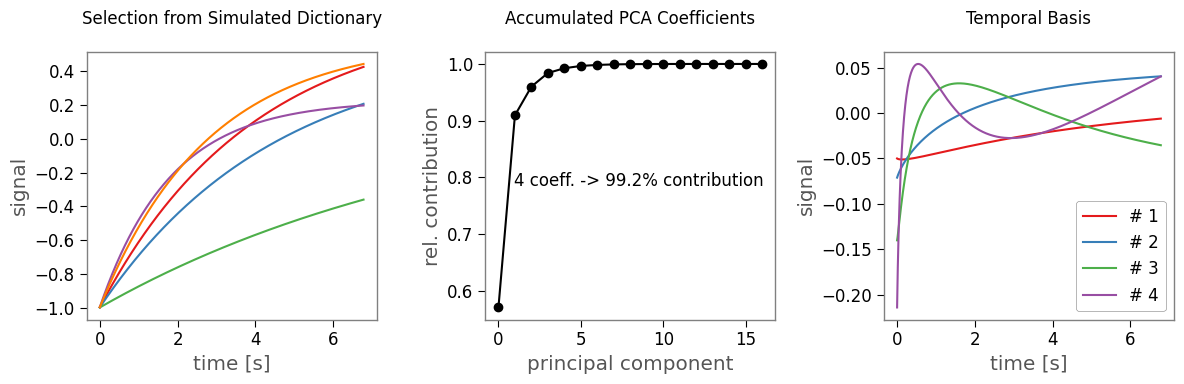

In [28]:
ps.plotSubspace()

### Estimate Coil Sensitivities Using Subspace
We realized, that 4 PCA coefficients contribute to more than 99% of the observed signal. Hence, we can reduce our basis to only contain the first 4 eigenvectors. We create a subspace basis spanned by those 4 eigenvectors.

In [7]:
nCoe = 4 ## use 4 coefficients

In [29]:
%%pybash

# create the temporal basis
bart extract 1 0 {nCoe} U subbasis
# transpose the basis to have time on the 6th dimension and coefficients on the 5th dimension
bart transpose 1 6 subbasis - | bart transpose 0 5 - subbasis 

For consistency, check dimensions of subbasis, input data and trajectory:

In [30]:
%%bash 

head -n2 subbasis.hdr
head -n2 data/ksp_MID00019.hdr
head -n2 traj.hdr


# Dimensions
1 1 1 1 1 1131 4 1 1 1 1 1 1 1 1 1 
# Dimensions
1 512 1 18 1 1131 1 1 1 1 1 1 1 1 1 1 
# Dimensions
3 512 1 1 1 1131 1 1 1 1 1 1 1 1 1 1 



 Now, we estimate coil sensitivities using `bart ncalib` and reduced subspace basis in one go. 

In [31]:
%%bash

DEBUG_LEVEL=4 bart ncalib -N -i16 -t traj -B subbasis data/ksp_MID00019 sens_ncalib

Est. image size: 256 256 1
ksp : [  1 512   1  18   1 1131   1   1   1   1   1   1   1   1   1   1 ]
cim : [ 48  48   1  18   1   1   4   1   1   1   1   1   1   1   1   1 ]
traj: [  3 512   1   1   1 1131   1   1   1   1   1   1   1   1   1   1 ]
wgh : [  1 512   1   1   1 1131   1   1   1   1   1   1   1   1   1   1 ]
bas : [  1   1   1   1   1 1131   4   1   1   1   1   1   1   1   1   1 ]
NUFFT: low-mem mode
NUFFT: Toeplitz mode

Model created (non Cartesian, nufft-based):
kspace:     [  1 512   1  18   1 1131   1   1   1   1   1   1   1   1   1   1 ]
images:     [ 48  48   1   1   1   1   4   1   1   1   1   1   1   1   1   1 ]
coils:      [ 16  16   1  18   1   1   1   1   1   1   1   1   1   1   1   1 ]
trajectory: [  3 512   1   1   1 1131   1   1   1   1   1   1   1   1   1   1 ]
pattern:    [  1 512   1   1   1 1131   1   1   1   1   1   1   1   1   1   1 ]
basis:      [  1   1   1   1   1 1131   4   1   1   1   1   1   1   1   1   1 ]
mask:       [  1   1   1   1   1   1   1

### Perform reconstruction 

Using estimated coil sensitvities, we can now perform parrallel imaging reconstruction with `bart pics`. We use the following parameter for iterations and regularization.

In [32]:
ITER=100
REG=0.0005


In [33]:
%%pybash
# # reconstruction with subspace constraint
bart pics -g -e -d5 -i {ITER} -R W:$(bart bitmask 0 1):$(bart bitmask 6):{REG} -B subbasis -t traj data/ksp_MID00019 sens_ncalib subspace_reco

Basis: [256 256   1  18   1 1131   4   1   1   1   1   1   1   1   1   1 ]
Max:   [256 256   1  18   1   1   4   1   1   1   1   1   1   1   1   1 ]
GPU reconstruction
[  1 512   1  18   1 1131   4   1   1   1   1   1   1   1   1   1 ]
[256 256   1  18   1   1   4   1   1   1   1   1   1   1   1   1 ]
ksp : [  1 512   1  18   1 1131   4   1   1   1   1   1   1   1   1   1 ]
cim : [256 256   1  18   1   1   4   1   1   1   1   1   1   1   1   1 ]
traj: [  3 512   1   1   1 1131   1   1   1   1   1   1   1   1   1   1 ]
wgh : [  1 512   1   1   1 1131   1   1   1   1   1   1   1   1   1   1 ]
bas : [  1   1   1   1   1 1131   4   1   1   1   1   1   1   1   1   1 ]
NUFFT: Toeplitz mode
psf_dims: [256 256   1   1   1 1131   1   1   1   1   1   1   1   1   1   1 ]
ksp : [  1 512   1   1   1 1131   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [512 512   1   1   1   1  16   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 512   1   1   1 1131   1   1   1   1   1   1   1   1   1   1   

We can visualize the first 4 coefficients projected onto our data set

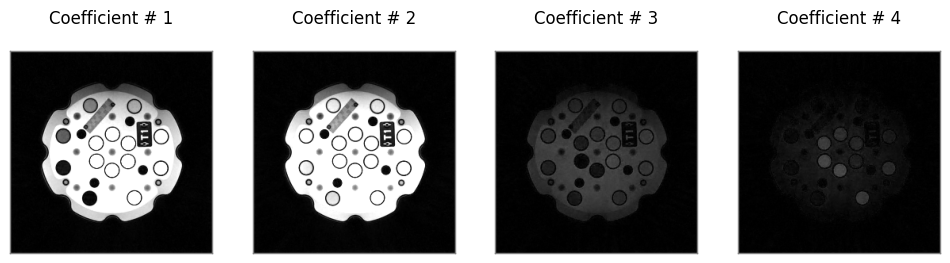

In [34]:
ps.plotCoefficientMaps()


In [8]:
%%bash
## by chance, 2nd coefficient map also suitable for mask 
bart slice 6 1 subspace_reco - | bart threshold -B 0.3 - mask
bart fmac mask subspace_reco subspace_reco

 : No such file or directory
Loading cfl file subspace_reco
ERROR: ERROR: Reading input from -
bash: line 2: 816448 Aborted                 bart slice 6 1 subspace_reco -
     816449                       | bart threshold -B 0.3 - mask
 : No such file or directory
Loading cfl file mask
ERROR: bash: line 3: 816480 Aborted                 bart fmac mask subspace_reco subspace_reco


CalledProcessError: Command 'b'## by chance, 2nd coefficient map also suitable for mask \nbart slice 6 1 subspace_reco - | bart threshold -B 0.3 - mask\nbart fmac mask subspace_reco subspace_reco\n'' returned non-zero exit status 134.

### Temporal Signal Evolution

We can also project our subbasis onto all spokes, resulting in temporal signal evolution.

In [9]:
%%bash 
bart fmac -s $(bart bitmask 6) subbasis subspace_reco imgs

 : No such file or directory
Loading cfl file subbasis
ERROR: bash: line 1: 816529 Aborted                 bart fmac -s $(bart bitmask 6) subbasis subspace_reco imgs


CalledProcessError: Command 'b'bart fmac -s $(bart bitmask 6) subbasis subspace_reco imgs\n'' returned non-zero exit status 134.

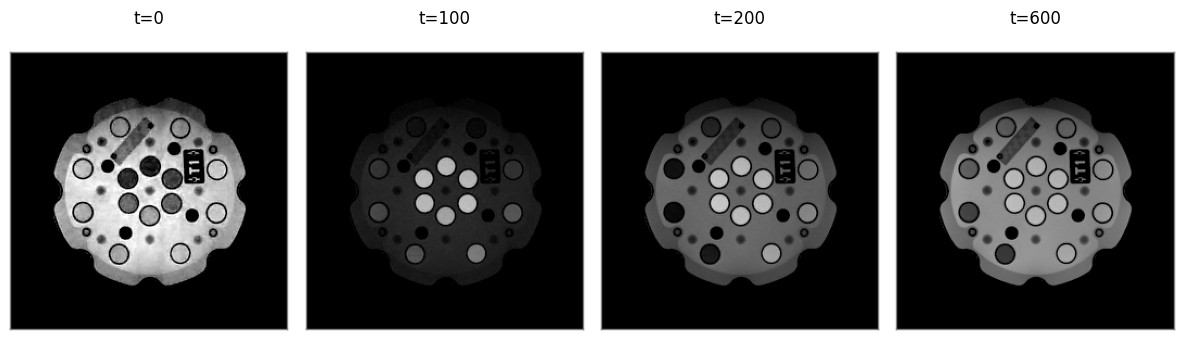

In [37]:
importlib.reload(ps)
ps.plotTemporalEvolution()


### T1 Map from Reconstructed Images
Using `bart mobafit` we obtain T1 parameter map via pixel-wise fitting. 

In [38]:
%%pybash
### create vector with inversion times nREP*TR
bart index 5 {REP} - | bart scale {TR} - TI

DEBUG_LEVEL=4 bart mobafit -g -i20 --init 1:1:1 -B subbasis -L TI subspace_reco - | bart looklocker -t0 -D15.3e-3 - t1map

Temp file for pipe: bart-aT5vlj
Step: 0, Res: 5748.667991
	 cg:  11
Step: 1, Res: 144.627954
	 cg:  10
Step: 2, Res: 274458.084239
	 cg:  50
Step: 3, Res: nan
	 cg:  50
Step: 4, Res: nan
	 cg:  50
Step: 5, Res: nan
	 cg:  50
Step: 6, Res: nan
	 cg:  50
Step: 7, Res: nan
	 cg:  50
Step: 8, Res: nan
	 cg:  50
Step: 9, Res: nan
	 cg:  50
Step: 10, Res: nan
	 cg:  50
Step: 11, Res: nan
	 cg:  50
Step: 12, Res: nan
	 cg:  50
Step: 13, Res: nan
	 cg:  50
Step: 14, Res: nan
	 cg:  50
Step: 15, Res: nan
	 cg:  50
Step: 16, Res: nan
	 cg:  50
Step: 17, Res: nan
	 cg:  50
Step: 18, Res: nan
	 cg:  50
Step: 19, Res: nan
	 cg:  50
Total Time: 2.49 s
Freed 3611607760 bytes.


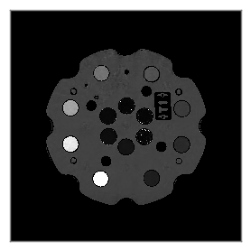

In [39]:
importlib.reload(ps)
ps.plotT1Map()